# Forecasting crime with Facebook Prophet

#### 1. Import libraries and data

In [82]:
import pandas as pd 
import numpy as np 


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge

from prophet import Prophet 
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt 
%matplotlib inline

import itertools

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

import holidays

import plotly.graph_objs as go

from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_yearly, add_changepoints_to_plot
plt.style.use('fivethirtyeight')

In [83]:
# Read the data
df = pd.read_csv('../data/lrpd-clean.csv')

#### 2. Reducing memory helps us do feature engineering faster and more efficiently

In [84]:
# Reduce memory like we did in data cleanup
def reduce_mem_usage(df, category=False):
  start_mem = df.memory_usage().sum() / 1024 **2
  print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

  for col in df.columns:
    col_type = df[col].dtype

    if col_type != object:
      c_min = df[col].min()
      c_max = df[col].max()
      if str(col_type)[:3] == 'int':
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
          df[col] = df[col].astype(np.int8)
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
          df[col] = df[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
          df[col] = df[col].astype(np.int32)
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
          df[col] = df[col].astype(np.int64)
      else:
        if c_min  > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
          df[col] = df[col].astype(np.float16)
        elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
          df[col] = df[col].astype(np.float32)
        else:
          df[col] = df[col].astype(np.float64)
    else:
      if category:
        df[col] = df[col].astype('category')

  end_mem = df.memory_usage().sum() / 1024 ** 2
  print('Memory usage after optimizations: {:.2f} MB'.format(end_mem))
  print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
  return df

df = reduce_mem_usage(df)

Memory usage of dataframe is 10.60 MB
Memory usage after optimizations: 5.47 MB
Decreased by 48.4%


#### 3. Set correct data types

In [85]:
df["INCIDENT_DATE"] = pd.to_datetime(df["INCIDENT_DATE"])
df.dtypes

INCIDENT_NUMBER                object
INCIDENT_DATE          datetime64[ns]
LOCATION_DISTRICT             float16
OFFENSE_DESCRIPTION            object
WEAPON_TYPE                    object
ZIP                           float32
LATITUDE                      float16
LONGITUDE                     float16
WEEK_OF_MONTH                    int8
YEAR                            int16
DAY                              int8
DAY_OF_YEAR                     int16
MONTH                            int8
CRIME_TYPE                     object
RISK_TYPE                      object
RISK_TYPE_BC                     int8
dtype: object

#### 4. Prophet takes a dataframe with two columns: ds and y.
* The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.
*  The y column must be numeric, and represents the measurement we wish to forecast.

In [86]:
df = df.groupby(pd.Grouper(key='INCIDENT_DATE', freq='D')).size().reset_index(name='INCIDENT_COUNT')
df.columns = ['ds', 'y']

In [87]:
len(df)

2242

#### 5. Make a baseline model using Prophet to see how well the model does without adding regressors, holidays or hyperparameter tuning.

In [88]:
np.random.seed(42)
# Split the data into train and test sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

# Initialize and fit the model on the train set
m = Prophet()
m.fit(train_df)

# Make predictions for the train and test sets
future_train = m.make_future_dataframe(periods=len(train_df))
forecast_train = m.predict(future_train)

future_test = m.make_future_dataframe(periods=len(test_df))
forecast_test = m.predict(future_test)

# Evaluate performance on the train set
y_true_train = train_df['y'].values
y_pred_train = forecast_train['yhat'].values[:len(train_df)]
rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))

print("Train RMSE:", rmse_train)

# Evaluate performance on the test set
y_true_test = test_df['y'].values
y_pred_test = forecast_test['yhat'].values[-len(test_df):]
rmse_test_baseline = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

print("Test RMSE:", rmse_test_baseline)


12:27:33 - cmdstanpy - INFO - Chain [1] start processing
12:27:33 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.74044614071794
Test RMSE: 9.09809956126226


#### 6. Lets add holidays to the model to see how well it does.

In [89]:
# We will add covid data as instructed by Prophet in order to capture the impact of the pandemic on the data
np.random.seed(42)
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06', 'upper_window': 77},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27', 'upper_window': 110},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17', 'upper_window': 4},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10', 'upper_window': 13},
])

m3_changepoints = (
    # 10 potential changepoints in 2.5 years
    pd.date_range('2017-06-02', '2020-01-01', periods=10).date.tolist() +
    # 15 potential changepoints in 1 year 2 months
    pd.date_range('2020-02-01', '2021-04-01', periods=15).date.tolist()
)

df['pre_covid'] = pd.to_datetime(df['ds']) < pd.to_datetime('2020-03-21')
df['post_covid'] = ~df['pre_covid']

m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, holidays=lockdowns, changepoints=m3_changepoints)

m.add_seasonality(
    name='weekly_pre_covid',
    period=7,
    fourier_order=3,
    condition_name='pre_covid',
)
m.add_seasonality(
    name='weekly_post_covid',
    period=7,
    fourier_order=3,
    condition_name='post_covid',
)

train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

m.add_country_holidays(country_name='US')
m.fit(train_df)

future_train = m.make_future_dataframe(periods=len(train_df))
future_train['pre_covid'] = pd.to_datetime(future_train['ds']) < pd.to_datetime('2020-03-21')
future_train['post_covid'] = ~future_train['pre_covid']
forecast_train = m.predict(future_train)

future_test = m.make_future_dataframe(periods=len(test_df))
future_test['pre_covid'] = pd.to_datetime(future_test['ds']) < pd.to_datetime('2020-03-21')
future_test['post_covid'] = ~future_test['pre_covid']
forecast_test = m.predict(future_test)

# Evaluate performance on the train set
y_true_train = train_df['y'].values
y_pred_train = forecast_train['yhat'].values[:len(train_df)]
rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))

print("Train RMSE:", rmse_train)

# Evaluate performance on the test set
y_true_test = test_df['y'].values
y_pred_test = forecast_test['yhat'].values[-len(test_df):]
rmse_test_holiday = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

print("Test RMSE:", rmse_test_holiday)


12:27:34 - cmdstanpy - INFO - Chain [1] start processing
12:27:34 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.877684200609642
Test RMSE: 8.098248310442294


## Putting it all together

* Now we can start putting everything together by hyperparameter tuning, adding holidays, and eventually adding weather data as well.

In [90]:
df = pd.read_csv('../data/lrpd-clean.csv')
df['INCIDENT_DATE'] = pd.to_datetime(df['INCIDENT_DATE'])
df = df.groupby(pd.Grouper(key='INCIDENT_DATE', freq='D')).size().reset_index(name='INCIDENT_COUNT')
df.columns = ['ds', 'y']
df.shape


(2242, 2)

In [91]:
# Split the data into train and test sets
df['pre_covid'] = pd.to_datetime(df['ds']) < pd.to_datetime('2020-03-21')
df['post_covid'] = ~df['pre_covid']

train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

#### HYPERPARAMETER TUNING #1

In [92]:
np.random.seed(42)
# Define the parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.5],
    'seasonality_prior_scale': [0.01, 10],
    'holidays_prior_scale': [0.01, 10],
    'seasonality_mode': ['additive', 'multiplicative'],
    'daily_seasonality': [True, False],
    'weekly_seasonality': [False],
    'yearly_seasonality': [True, False],
    'holidays': [lockdowns],
    'changepoints': [m3_changepoints]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

for params in all_params:
    m = Prophet(**params)
    m.add_seasonality(
    name='weekly_pre_covid',
    period=7,
    fourier_order=3,
    condition_name='pre_covid',
    )
    m.add_seasonality(
        name='weekly_post_covid',
        period=7,
        fourier_order=3,
        condition_name='post_covid',
    )
    m.fit(train_df)
    future_train = m.make_future_dataframe(periods=len(train_df))
    future_train['pre_covid'] = pd.to_datetime(future_train['ds']) < pd.to_datetime('2020-03-21')
    future_train['post_covid'] = ~future_train['pre_covid']
    forecast_train = m.predict(future_train)

    future_test = m.make_future_dataframe(periods=len(test_df))
    future_test['pre_covid'] = pd.to_datetime(future_test['ds']) < pd.to_datetime('2020-03-21')
    future_test['post_covid'] = ~future_test['pre_covid']
    forecast_test = m.predict(future_test)

    # Evaluate performance on the train set
    y_true_train = train_df['y'].values
    y_pred_train = forecast_train['yhat'].values[:len(train_df)]
    rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))

    # Evaluate performance on the test set
    y_true_test = test_df['y'].values
    y_pred_test = forecast_test['yhat'].values[-len(test_df):]
    rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

    rmses.append(rmse_test)

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

# Python
best_params = all_params[np.argmin(rmses)]
print(best_params)


12:27:36 - cmdstanpy - INFO - Chain [1] start processing
12:27:36 - cmdstanpy - INFO - Chain [1] done processing
12:27:37 - cmdstanpy - INFO - Chain [1] start processing
12:27:37 - cmdstanpy - INFO - Chain [1] done processing
12:27:38 - cmdstanpy - INFO - Chain [1] start processing
12:27:38 - cmdstanpy - INFO - Chain [1] done processing
12:27:39 - cmdstanpy - INFO - Chain [1] start processing
12:27:39 - cmdstanpy - INFO - Chain [1] done processing
12:27:40 - cmdstanpy - INFO - Chain [1] start processing
12:27:40 - cmdstanpy - INFO - Chain [1] done processing
12:27:42 - cmdstanpy - INFO - Chain [1] start processing
12:27:42 - cmdstanpy - INFO - Chain [1] done processing
12:27:43 - cmdstanpy - INFO - Chain [1] start processing
12:27:43 - cmdstanpy - INFO - Chain [1] done processing
12:27:44 - cmdstanpy - INFO - Chain [1] start processing
12:27:44 - cmdstanpy - INFO - Chain [1] done processing
12:27:45 - cmdstanpy - INFO - Chain [1] start processing
12:27:45 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale   
0                     0.001                     0.01                  0.01  \
1                     0.001                     0.01                  0.01   
2                     0.001                     0.01                  0.01   
3                     0.001                     0.01                  0.01   
4                     0.001                     0.01                  0.01   
..                      ...                      ...                   ...   
59                    0.500                    10.00                 10.00   
60                    0.500                    10.00                 10.00   
61                    0.500                    10.00                 10.00   
62                    0.500                    10.00                 10.00   
63                    0.500                    10.00                 10.00   

   seasonality_mode  daily_seasonality  weekly_seasonality   
0

#### We fit the model with the best parameters, and the holidays data.

In [94]:
np.random.seed(42)
m = Prophet(**best_params)
m.add_country_holidays(country_name='US')
m.add_seasonality(
    name='weekly_pre_covid',
    period=7,
    fourier_order=3,
    condition_name='pre_covid',
)
m.add_seasonality(
    name='weekly_post_covid',
    period=7,
    fourier_order=3,
    condition_name='post_covid',
)
m.fit(train_df)

future_train = m.make_future_dataframe(periods=len(train_df))
future_train['pre_covid'] = pd.to_datetime(future_train['ds']) < pd.to_datetime('2020-03-21')
future_train['post_covid'] = ~future_train['pre_covid']
forecast_train = m.predict(future_train)

future_test = m.make_future_dataframe(periods=len(test_df))
future_test['pre_covid'] = pd.to_datetime(future_test['ds']) < pd.to_datetime('2020-03-21')
future_test['post_covid'] = ~future_test['pre_covid']
forecast_test = m.predict(future_test)

# Evaluate performance on the train set
y_true_train = train_df['y'].values
y_pred_train = forecast_train['yhat'].values[:len(train_df)]
rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))

print("Train RMSE:", rmse_train)

# Evaluate performance on the test set
y_true_test = test_df['y'].values
y_pred_test = forecast_test['yhat'].values[-len(test_df):]
rmse_test_tuned = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

print("Test RMSE:", rmse_test_tuned)


12:29:15 - cmdstanpy - INFO - Chain [1] start processing
12:29:16 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.707875388532917
Test RMSE: 7.8352480538402425


#### We add weather data from the local Little Rock airport weather station to the model

It is important to note that we will also need the weather data for the future in order to make forecasts on the future. 

We can obtain that data by using a weather data API to get the weather forecast for the horizon.

In [95]:
weather = pd.read_csv('../data/weather.csv')
best_data = weather[weather['NAME'] == 'LITTLE ROCK AIRPORT ADAMS FIELD, AR US']
columns_to_keep = ['DATE', 'AWND', 'PRCP', 'SNWD', 'SNOW', 'TMAX', 'TMIN']
best_data = best_data[columns_to_keep]
best_data.fillna(0, inplace=True)
best_data = best_data[best_data['DATE'] < '2023-02-21']
best_data['DATE'] = pd.to_datetime(best_data['DATE'])
best_df = pd.merge(df, best_data, left_on='ds', right_on='DATE', how='inner')
best_df.drop(columns=['DATE'], inplace=True)

In [96]:
best_df.head()

,ds,y,pre_covid,post_covid,AWND,PRCP,SNWD,SNOW,TMAX,TMIN
0,2017-01-01,54,True,False,6.93,0.01,0.0,0.0,46.0,43.0
1,2017-01-02,45,True,False,5.37,0.20,0.0,0.0,56.0,45.0
2,2017-01-03,49,True,False,7.61,0.00,0.0,0.0,57.0,40.0
3,2017-01-04,48,True,False,9.62,0.00,0.0,0.0,41.0,26.0
4,2017-01-05,39,True,False,8.50,0.00,0.0,0.0,37.0,29.0


Perform hyperparameter tuning after added regressors too. 

In [97]:
finalDf = pd.read_csv('../data/final-lrpd-data.csv')
list2 = ['is_holiday', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear', 'is_weekend', 'is_weekday',
       'season', 'AWND', 'PRCP', 'SNWD', 'SNOW', 'TMAX', 'TMIN']
estimator = Ridge()
selector = RFECV(estimator, step=10, cv=10)
selector = selector.fit(finalDf[list2], finalDf['y'])
to_keep = finalDf[list2].columns[selector.support_]


#### HYPERPARAMETER TUNING #2 

In [98]:
np.random.seed(42)
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.5],
    'seasonality_prior_scale': [0.01, 10],
    'holidays_prior_scale': [0.01, 10],
    'seasonality_mode': ['additive', 'multiplicative'],
    'daily_seasonality': [True, False],
    'weekly_seasonality': [False],
    'yearly_seasonality': [True, False],
    'holidays': [lockdowns],
    'changepoints': [m3_changepoints]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

for params in all_params:

    m = Prophet(**params)
    m.add_country_holidays(country_name='US')
    m.add_seasonality(
    name='weekly_pre_covid',
    period=7,
    fourier_order=3,
    condition_name='pre_covid',
    )
    m.add_seasonality(
        name='weekly_post_covid',
        period=7,
        fourier_order=3,
        condition_name='post_covid',
    )
    # Add regressors to the dataframe
    for f in to_keep:
        df[f] = finalDf[f]
        m.add_regressor(f)

    train_size = int(len(df) * 0.8)
    train_df = df[:train_size]
    test_df = df[train_size:]

    m.fit(train_df)

    future_train = train_df.drop(columns=['y']).copy()
    future_train['pre_covid'] = pd.to_datetime(future_train['ds']) < pd.to_datetime('2020-03-21')
    future_train['post_covid'] = ~future_train['pre_covid']
   
    for f in to_keep:
        future_train[f] = finalDf[f][:train_size]

    forecast_train = m.predict(future_train)

    # Evaluate performance on the train set
    y_true_train = train_df['y'].values
    y_pred_train = forecast_train['yhat'].values[:len(train_df)]
    rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))

    print("Train RMSE:", rmse_train)

    future_test = test_df.drop(columns=['y']).copy()
    future_test['pre_covid'] = pd.to_datetime(future_test['ds']) < pd.to_datetime('2020-03-21')
    future_test['post_covid'] = ~future_test['pre_covid']
    # Evaluate performance on the test set
    for f in to_keep:
        future_test[f] = finalDf[f][train_size:]

    forecast_test = m.predict(future_test)

    y_true_test = test_df['y'].values
    y_pred_test = forecast_test['yhat'].values[-len(test_df):]
    rmse_test_weather = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

    rmses.append(rmse_test_weather)


# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

# Python
best_params = all_params[np.argmin(rmses)]
print(best_params)

12:29:17 - cmdstanpy - INFO - Chain [1] start processing
12:29:18 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.721414545372114


12:29:18 - cmdstanpy - INFO - Chain [1] start processing
12:29:18 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.831219356122382


12:29:19 - cmdstanpy - INFO - Chain [1] start processing
12:29:19 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.729286738255866


12:29:20 - cmdstanpy - INFO - Chain [1] start processing
12:29:20 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.840006138056904


12:29:21 - cmdstanpy - INFO - Chain [1] start processing
12:29:21 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.880918674981554


12:29:22 - cmdstanpy - INFO - Chain [1] start processing
12:29:22 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.026380273964199


12:29:23 - cmdstanpy - INFO - Chain [1] start processing
12:29:24 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.927261373763784


12:29:24 - cmdstanpy - INFO - Chain [1] start processing
12:29:24 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.053422545617419


12:29:25 - cmdstanpy - INFO - Chain [1] start processing
12:29:25 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.710283122477661


12:29:26 - cmdstanpy - INFO - Chain [1] start processing
12:29:26 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.826568542177538


12:29:27 - cmdstanpy - INFO - Chain [1] start processing
12:29:27 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.720909801797481


12:29:28 - cmdstanpy - INFO - Chain [1] start processing
12:29:28 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.816015043745819


12:29:29 - cmdstanpy - INFO - Chain [1] start processing
12:29:29 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.918910831033566


12:29:30 - cmdstanpy - INFO - Chain [1] start processing
12:29:30 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.030447746819522


12:29:31 - cmdstanpy - INFO - Chain [1] start processing
12:29:31 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.937962259902483


12:29:32 - cmdstanpy - INFO - Chain [1] start processing
12:29:32 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.076994047194972


12:29:33 - cmdstanpy - INFO - Chain [1] start processing
12:29:33 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.711288476688243


12:29:34 - cmdstanpy - INFO - Chain [1] start processing
12:29:34 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.8154926476953275


12:29:35 - cmdstanpy - INFO - Chain [1] start processing
12:29:35 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.714173624744627


12:29:36 - cmdstanpy - INFO - Chain [1] start processing
12:29:36 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.82525011262562


12:29:37 - cmdstanpy - INFO - Chain [1] start processing
12:29:37 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.760799285013702


12:29:38 - cmdstanpy - INFO - Chain [1] start processing
12:29:38 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.889557788289345


12:29:39 - cmdstanpy - INFO - Chain [1] start processing
12:29:39 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.833731983086179


12:29:40 - cmdstanpy - INFO - Chain [1] start processing
12:29:40 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.8873189195784565


12:29:41 - cmdstanpy - INFO - Chain [1] start processing
12:29:41 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.690873522459348


12:29:42 - cmdstanpy - INFO - Chain [1] start processing
12:29:42 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.805056550011082


12:29:43 - cmdstanpy - INFO - Chain [1] start processing
12:29:43 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.696975164816211


12:29:44 - cmdstanpy - INFO - Chain [1] start processing
12:29:44 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.804046771989323


12:29:44 - cmdstanpy - INFO - Chain [1] start processing
12:29:45 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.8729800164556485


12:29:45 - cmdstanpy - INFO - Chain [1] start processing
12:29:46 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.973873000197149


12:29:46 - cmdstanpy - INFO - Chain [1] start processing
12:29:46 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.882877518430281


12:29:47 - cmdstanpy - INFO - Chain [1] start processing
12:29:47 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.050995890883469


12:29:48 - cmdstanpy - INFO - Chain [1] start processing
12:29:49 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.167196262620689


12:29:50 - cmdstanpy - INFO - Chain [1] start processing
12:29:52 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.271044676039409


12:29:52 - cmdstanpy - INFO - Chain [1] start processing
12:29:53 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.165287015775838


12:29:54 - cmdstanpy - INFO - Chain [1] start processing
12:29:55 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.2726526562235


12:29:56 - cmdstanpy - INFO - Chain [1] start processing
12:29:57 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.2456397243216


12:29:58 - cmdstanpy - INFO - Chain [1] start processing
12:29:59 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.348491489522036


12:30:00 - cmdstanpy - INFO - Chain [1] start processing
12:30:00 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.252307117448315


12:30:01 - cmdstanpy - INFO - Chain [1] start processing
12:30:01 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.3511608766789385


12:30:02 - cmdstanpy - INFO - Chain [1] start processing
12:30:03 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.5745629538257075


12:30:04 - cmdstanpy - INFO - Chain [1] start processing
12:30:05 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.694128133397165


12:30:06 - cmdstanpy - INFO - Chain [1] start processing
12:30:07 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.576356265363822


12:30:08 - cmdstanpy - INFO - Chain [1] start processing
12:30:09 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.6941152751419075


12:30:10 - cmdstanpy - INFO - Chain [1] start processing
12:30:12 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.6706090906196405


12:30:13 - cmdstanpy - INFO - Chain [1] start processing
12:30:14 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.720876428131471


12:30:15 - cmdstanpy - INFO - Chain [1] start processing
12:30:17 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.667112876752268


12:30:18 - cmdstanpy - INFO - Chain [1] start processing
12:30:19 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.720974275753401


12:30:20 - cmdstanpy - INFO - Chain [1] start processing
12:30:21 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.138736780874536


12:30:22 - cmdstanpy - INFO - Chain [1] start processing
12:30:23 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.2592196411824705


12:30:24 - cmdstanpy - INFO - Chain [1] start processing
12:30:25 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.13974508814477


12:30:26 - cmdstanpy - INFO - Chain [1] start processing
12:30:27 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.259426551693983


12:30:28 - cmdstanpy - INFO - Chain [1] start processing
12:30:29 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.155230788976825


12:30:30 - cmdstanpy - INFO - Chain [1] start processing
12:30:31 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.2760217975644395


12:30:32 - cmdstanpy - INFO - Chain [1] start processing
12:30:32 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.157271921621268


12:30:33 - cmdstanpy - INFO - Chain [1] start processing
12:30:34 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.274841381121727


12:30:34 - cmdstanpy - INFO - Chain [1] start processing
12:30:37 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.555401925368804


12:30:37 - cmdstanpy - INFO - Chain [1] start processing
12:30:39 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.680598856972859


12:30:40 - cmdstanpy - INFO - Chain [1] start processing
12:30:41 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.556921166082639


12:30:41 - cmdstanpy - INFO - Chain [1] start processing
12:30:43 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.6812337197314795


12:30:43 - cmdstanpy - INFO - Chain [1] start processing
12:30:46 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.53569538879933


12:30:47 - cmdstanpy - INFO - Chain [1] start processing
12:30:51 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.657630638176819


12:30:51 - cmdstanpy - INFO - Chain [1] start processing
12:30:53 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.53755659810746


12:30:54 - cmdstanpy - INFO - Chain [1] start processing
12:30:56 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.661894353308856
    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale   
0                     0.001                     0.01                  0.01  \
1                     0.001                     0.01                  0.01   
2                     0.001                     0.01                  0.01   
3                     0.001                     0.01                  0.01   
4                     0.001                     0.01                  0.01   
..                      ...                      ...                   ...   
59                    0.500                    10.00                 10.00   
60                    0.500                    10.00                 10.00   
61                    0.500                    10.00                 10.00   
62                    0.500                    10.00                 10.00   
63                    0.500                    10.00                 10.00   

   seasonality_mode  daily_season

Training with the best params!

In [100]:
np.random.seed(42)
m = Prophet(**best_params)
m.add_country_holidays(country_name='US')
m.add_seasonality(
    name='weekly_pre_covid',
    period=7,
    fourier_order=3,
    condition_name='pre_covid',
)
m.add_seasonality(
    name='weekly_post_covid',
    period=7,
    fourier_order=3,
    condition_name='post_covid',
)
# Add regressors to the dataframe
for f in to_keep:
    df[f] = finalDf[f]
    m.add_regressor(f)

train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

m.fit(train_df)


future_train = train_df.drop(columns=['y']).copy()
future_train['pre_covid'] = pd.to_datetime(future_train['ds']) < pd.to_datetime('2020-03-21')
future_train['post_covid'] = ~future_train['pre_covid']

for f in to_keep:
    future_train[f] = finalDf[f][:train_size]

forecast_train = m.predict(future_train)

# Evaluate performance on the train set
y_true_train = train_df['y'].values
y_pred_train = forecast_train['yhat'].values[:len(train_df)]
rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))

print("Train RMSE:", rmse_train)

future_test = test_df.drop(columns=['y']).copy()
future_test['pre_covid'] = pd.to_datetime(future_test['ds']) < pd.to_datetime('2020-03-21')
future_test['post_covid'] = ~future_test['pre_covid']
# Evaluate performance on the test set
for f in to_keep:
    future_test[f] = finalDf[f][train_size:]

forecast_test = m.predict(future_test)

y_true_test = test_df['y'].values
y_pred_test = forecast_test['yhat'].values[-len(test_df):]
rmse_test_weather = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
r2_test = r2_score(y_true_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test)
print("Test RMSE:", rmse_test_weather)
print('Test R2', r2_test)
print('MAPE', mape_test)

12:30:57 - cmdstanpy - INFO - Chain [1] start processing
12:30:58 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.157271921621268
Test RMSE: 7.5646519063390265
Test R2 0.30631117590195156
MAPE 0.17422262786584322


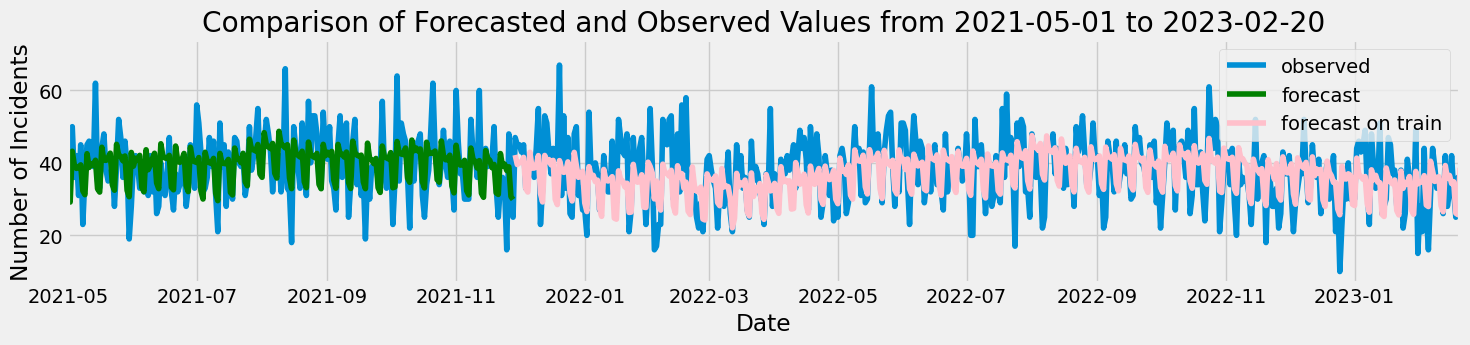

In [101]:
plt.figure(figsize=(13, 5))
plt.plot(df.ds, df.y, label='observed')


plt.plot(forecast_train['ds'], forecast_train['yhat'],
         label='forecast', color='green')
plt.plot(forecast_test['ds'], forecast_test['yhat'],
         label='forecast on train', color='pink')
plt.title('Comparison of Forecasted and Observed Values from 2021-05-01 to ' + str(forecast_test.ds.iloc[-1])[:10])
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()


plt.xlim(pd.Timestamp('2021-05-01'), pd.Timestamp(forecast_test.ds.iloc[-1]))
plt.gcf().set_size_inches(16, 3)
plt.savefig('../neural-prophet-forecast.png')
plt.show() 

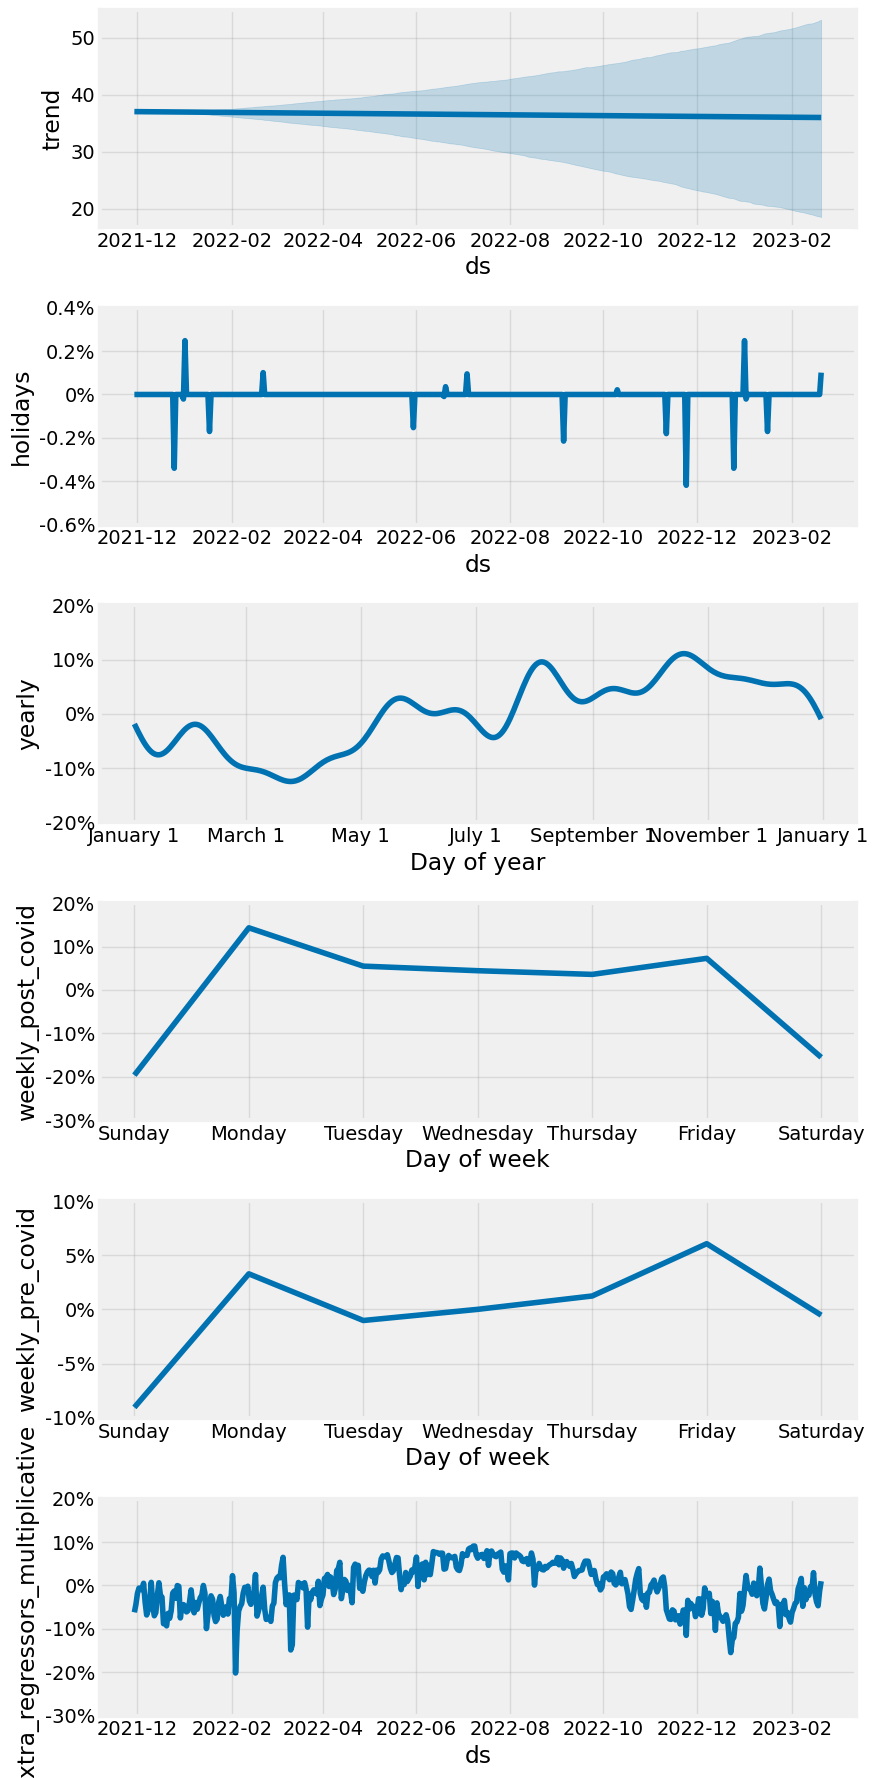

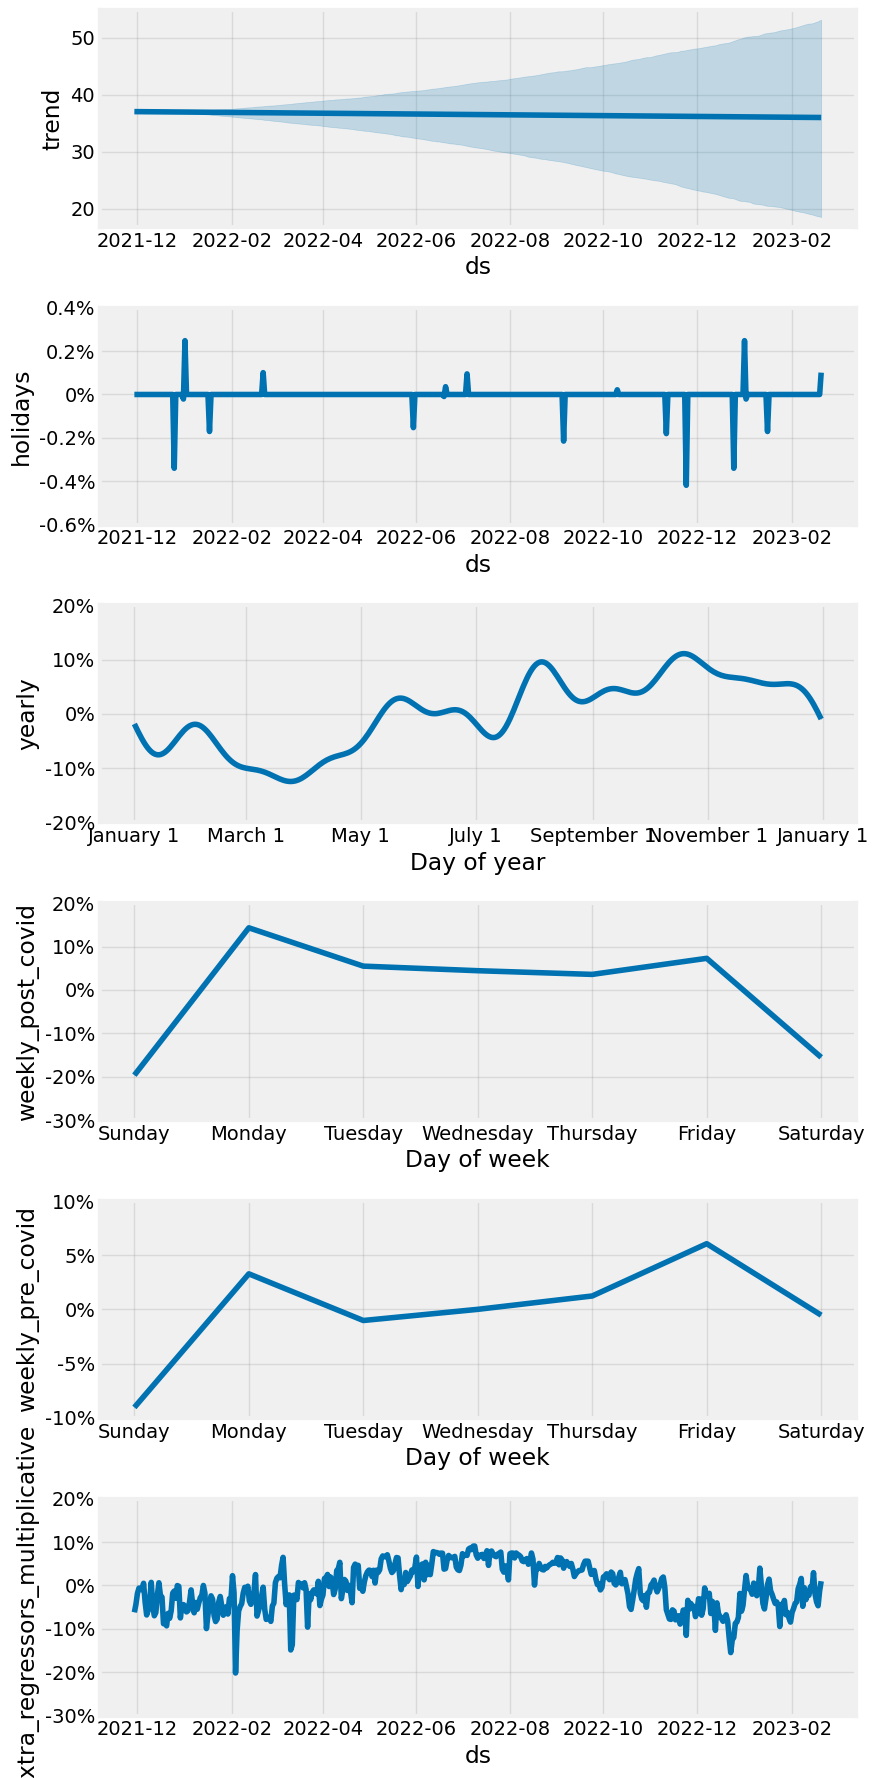

In [102]:
m.plot_components(forecast_test)

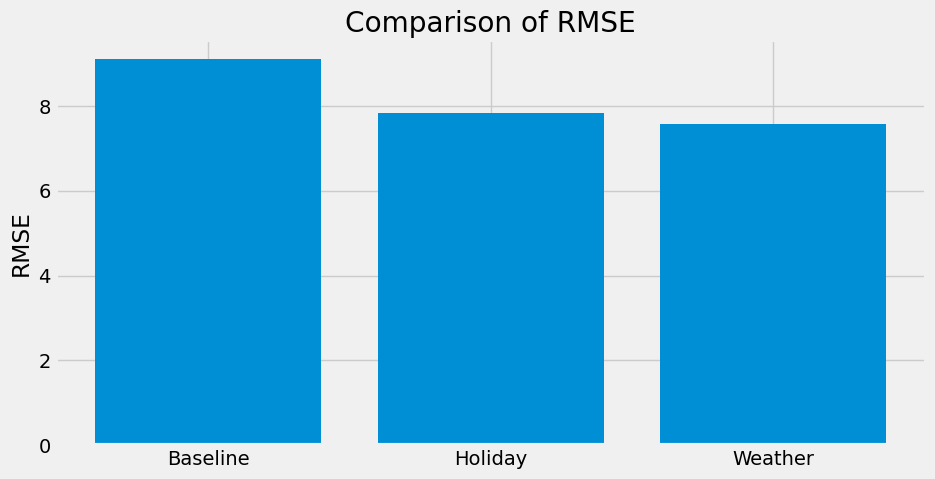

In [103]:
comparison = pd.DataFrame()
comparison['Model'] = ['Baseline', 'Holiday', 'Weather']
comparison['RMSE'] = [rmse_test_baseline, rmse_test_tuned, rmse_test_weather]
# plot the results
plt.figure(figsize=(10, 5))
plt.bar(comparison['Model'], comparison['RMSE'])
plt.title('Comparison of RMSE')
plt.ylabel('RMSE')
plt.show()